# 4.3 SGD를 사용한 MF 기본 알고리즘

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('C:/RecSys/Data/')

In [2]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        # rating_matrix
        self.R = np.array(ratings)
        # user, item 수 ← rating_matrix의 행, 열
        self.num_users, self.num_items = np.shape(self.R)
        
        # 잠재요인(latent factor) 수
        self.K = K
        # 학습률
        self.alpha = alpha
        # 정규화 계수
        self.beta = beta
        # 반복 횟수
        self.iterations = iterations
        # SGD 중간 학습과정 출력 여부
        self.verbose = verbose
    
    def rmse(self):
        # Rating Matrix에서 평점이 있는 요소의 인덱스만 가져옴
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        # r hat
        self.predictions = np.array(self.predictions)
        
        # 오차 계산
        self.errors = np.array(self.errors)
        
        return np.sqrt(np.mean(self.errors)**2)
    
    def train(self):
        # 평균이 0이고 표준편차가 1/k인 정규분포 난수 생성
        self.P = np.random.normal(0, 1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(0, 1./self.K, size=(self.num_items, self.K))

        # 사용자 평가경향 0으로 초기화 → 크기는 user의 수
        self.b_u = np.zeros(self.num_users)
        # 아이템 평가경향 0으로 초기화 → 크기는 item의 수
        self.b_d = np.zeros(self.num_items)
        # rating 전체 평균 구하기
        self.b = np.mean(self.R[self.R.nonzero()])


        # SGD를 적용할 평점이 있는 요소의 인덱스 및 평점을 가져와서 리스트로 만듦
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]

        # SGD RMSE 히스토리 반영
        training_process = []
        for i in range(self.iterations):
            # 어디서 시작하느냐에 따라서 수렴 속도가 달라질 수 있기 때문
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))

            # 중간결과 10번마다 출력
            if self.verbose:
                if (i+1)%10 == 0:
                    print("Iteration : %d; Train RMSE = %.4f" %(i+1, rmse))

        return training_process
    
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + np.dot(self.P[i, :], self.Q[j,:].T)
        return prediction
    
    def sgd(self):
        for i, j, r in self.samples:
            # 사용자 i, 아이템 j에 대한 평점 예측치
            prediction = self.get_prediction(i, j)
            
            # 오차 구하기
            e = (r - prediction)
            
            # update
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

In [4]:
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
train_process = mf.train()

Iteration : 10; Train RMSE = 0.0236
Iteration : 20; Train RMSE = 0.0164
Iteration : 30; Train RMSE = 0.0125
Iteration : 40; Train RMSE = 0.0102
Iteration : 50; Train RMSE = 0.0086
Iteration : 60; Train RMSE = 0.0070
Iteration : 70; Train RMSE = 0.0063
Iteration : 80; Train RMSE = 0.0053
Iteration : 90; Train RMSE = 0.0050
Iteration : 100; Train RMSE = 0.0048


---

# 4.4 train_test 분리 MF 알고리즘

In [5]:
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75

ratings = shuffle(ratings, random_state=1)

# train_data 갯수 → cutoff
cutoff = int(TRAIN_SIZE * len(ratings))

# train_test_split
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.loc[cutoff:]

---

## 연습문제 4-1

shuffle없이 train_test_split 이용

In [6]:
# from sklearn.model_selection import train_test_split

# ratings_train, ratings_test = train_test_split(ratings, test_size=0.25)
# ratings_train

---

In [7]:
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        
        item_id_index = []
        index_item_id = []
        
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
            
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        
        user_id_index = []
        index_user_id = []
        
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
            
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
        
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose
        
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))
        
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + np.dot(self.P[i,:], self.Q[j,:].T)
        return prediction
        
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            # user_index 가져오기
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            # item_index 가져오기
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            # 해당 평점 가져오기
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            
            # 해당 평점 0으로 초기화 → train에서 제외
            self.R[x, y] = 0
        self.test_set = test_set
        return test_set
    
    def test_rmse(self):
        error = 0 
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))
    
    def test(self):
        self.P = np.random.normal(0, scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(0, scale=1./self.K, size=(self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]
        
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration : %d ; Train RMSE = %.4f ; Test RMSE = %.4f" %(i+1, rmse1, rmse2))
        return training_process
    
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])
    
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

In [8]:
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration : 10 ; Train RMSE = 1.0357 ; Test RMSE = 1.0571
Iteration : 20 ; Train RMSE = 0.9911 ; Test RMSE = 1.0273
Iteration : 30 ; Train RMSE = 0.9638 ; Test RMSE = 1.0117
Iteration : 40 ; Train RMSE = 0.9452 ; Test RMSE = 1.0026
Iteration : 50 ; Train RMSE = 0.9313 ; Test RMSE = 0.9969
Iteration : 60 ; Train RMSE = 0.9205 ; Test RMSE = 0.9932
Iteration : 70 ; Train RMSE = 0.9116 ; Test RMSE = 0.9906
Iteration : 80 ; Train RMSE = 0.9041 ; Test RMSE = 0.9887
Iteration : 90 ; Train RMSE = 0.8976 ; Test RMSE = 0.9874
Iteration : 100 ; Train RMSE = 0.8917 ; Test RMSE = 0.9865


In [9]:
print(mf.full_prediction())
print(mf.get_one_prediction(1, 2))

[[3.77912065 3.2357575  3.40996533 ... 3.31983506 3.32266977 3.32033941]
 [4.23631092 3.70482578 3.87802002 ... 3.78881624 3.79917813 3.79725443]
 [3.71974389 3.18785704 3.36292696 ... 3.27968291 3.26937953 3.27758298]
 ...
 [4.09105511 3.57561337 3.74930153 ... 3.65197818 3.64533562 3.65452599]
 [4.53350191 3.9964691  4.16974764 ... 4.09787888 4.09790829 4.09852168]
 [3.68992787 3.18941869 3.35199121 ... 3.26551179 3.24985703 3.24861239]]
3.2357575023786644


---

# 4.5 MF의 최적 파라미터 찾기

잠재요인의 수(K)에 따라, iterations의 수에 따라 정확도가 달라지므로 여러 번의 실험으로 최적의 정확도 찾기

In [10]:
results = []
index = []

for K in range(50, 261, 10):
    print('K = ', K)
    R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    
    # k를 담는 리트
    index.append(K)
    # iteration, train_rmse, test_rmse를 담는 리스트
    results.append(result)

K =  50
Iteration : 10 ; Train RMSE = 1.0359 ; Test RMSE = 1.0571
Iteration : 20 ; Train RMSE = 0.9915 ; Test RMSE = 1.0273
Iteration : 30 ; Train RMSE = 0.9646 ; Test RMSE = 1.0117
Iteration : 40 ; Train RMSE = 0.9461 ; Test RMSE = 1.0026
Iteration : 50 ; Train RMSE = 0.9325 ; Test RMSE = 0.9969
Iteration : 60 ; Train RMSE = 0.9220 ; Test RMSE = 0.9931
Iteration : 70 ; Train RMSE = 0.9134 ; Test RMSE = 0.9905
Iteration : 80 ; Train RMSE = 0.9062 ; Test RMSE = 0.9887
Iteration : 90 ; Train RMSE = 0.9000 ; Test RMSE = 0.9874
Iteration : 100 ; Train RMSE = 0.8945 ; Test RMSE = 0.9864
Iteration : 110 ; Train RMSE = 0.8897 ; Test RMSE = 0.9857
Iteration : 120 ; Train RMSE = 0.8852 ; Test RMSE = 0.9852
Iteration : 130 ; Train RMSE = 0.8810 ; Test RMSE = 0.9849
Iteration : 140 ; Train RMSE = 0.8771 ; Test RMSE = 0.9847
Iteration : 150 ; Train RMSE = 0.8733 ; Test RMSE = 0.9845
Iteration : 160 ; Train RMSE = 0.8696 ; Test RMSE = 0.9845
Iteration : 170 ; Train RMSE = 0.8659 ; Test RMSE = 0.984

Iteration : 200 ; Train RMSE = 0.8616 ; Test RMSE = 0.9847
Iteration : 210 ; Train RMSE = 0.8583 ; Test RMSE = 0.9848
Iteration : 220 ; Train RMSE = 0.8549 ; Test RMSE = 0.9850
Iteration : 230 ; Train RMSE = 0.8513 ; Test RMSE = 0.9852
Iteration : 240 ; Train RMSE = 0.8474 ; Test RMSE = 0.9854
Iteration : 250 ; Train RMSE = 0.8431 ; Test RMSE = 0.9856
Iteration : 260 ; Train RMSE = 0.8386 ; Test RMSE = 0.9858
Iteration : 270 ; Train RMSE = 0.8336 ; Test RMSE = 0.9860
Iteration : 280 ; Train RMSE = 0.8281 ; Test RMSE = 0.9862
Iteration : 290 ; Train RMSE = 0.8221 ; Test RMSE = 0.9864
Iteration : 300 ; Train RMSE = 0.8157 ; Test RMSE = 0.9866
K =  100
Iteration : 10 ; Train RMSE = 1.0361 ; Test RMSE = 1.0571
Iteration : 20 ; Train RMSE = 0.9920 ; Test RMSE = 1.0272
Iteration : 30 ; Train RMSE = 0.9652 ; Test RMSE = 1.0117
Iteration : 40 ; Train RMSE = 0.9469 ; Test RMSE = 1.0026
Iteration : 50 ; Train RMSE = 0.9335 ; Test RMSE = 0.9969
Iteration : 60 ; Train RMSE = 0.9232 ; Test RMSE = 0

Iteration : 90 ; Train RMSE = 0.9025 ; Test RMSE = 0.9873
Iteration : 100 ; Train RMSE = 0.8974 ; Test RMSE = 0.9864
Iteration : 110 ; Train RMSE = 0.8929 ; Test RMSE = 0.9857
Iteration : 120 ; Train RMSE = 0.8890 ; Test RMSE = 0.9852
Iteration : 130 ; Train RMSE = 0.8854 ; Test RMSE = 0.9849
Iteration : 140 ; Train RMSE = 0.8821 ; Test RMSE = 0.9847
Iteration : 150 ; Train RMSE = 0.8790 ; Test RMSE = 0.9845
Iteration : 160 ; Train RMSE = 0.8761 ; Test RMSE = 0.9845
Iteration : 170 ; Train RMSE = 0.8733 ; Test RMSE = 0.9845
Iteration : 180 ; Train RMSE = 0.8706 ; Test RMSE = 0.9845
Iteration : 190 ; Train RMSE = 0.8680 ; Test RMSE = 0.9846
Iteration : 200 ; Train RMSE = 0.8654 ; Test RMSE = 0.9847
Iteration : 210 ; Train RMSE = 0.8627 ; Test RMSE = 0.9849
Iteration : 220 ; Train RMSE = 0.8600 ; Test RMSE = 0.9850
Iteration : 230 ; Train RMSE = 0.8571 ; Test RMSE = 0.9852
Iteration : 240 ; Train RMSE = 0.8540 ; Test RMSE = 0.9854
Iteration : 250 ; Train RMSE = 0.8508 ; Test RMSE = 0.985

Iteration : 280 ; Train RMSE = 0.8446 ; Test RMSE = 0.9864
Iteration : 290 ; Train RMSE = 0.8407 ; Test RMSE = 0.9866
Iteration : 300 ; Train RMSE = 0.8365 ; Test RMSE = 0.9869
K =  190
Iteration : 10 ; Train RMSE = 1.0362 ; Test RMSE = 1.0571
Iteration : 20 ; Train RMSE = 0.9921 ; Test RMSE = 1.0272
Iteration : 30 ; Train RMSE = 0.9654 ; Test RMSE = 1.0116
Iteration : 40 ; Train RMSE = 0.9473 ; Test RMSE = 1.0025
Iteration : 50 ; Train RMSE = 0.9340 ; Test RMSE = 0.9968
Iteration : 60 ; Train RMSE = 0.9237 ; Test RMSE = 0.9931
Iteration : 70 ; Train RMSE = 0.9154 ; Test RMSE = 0.9905
Iteration : 80 ; Train RMSE = 0.9086 ; Test RMSE = 0.9887
Iteration : 90 ; Train RMSE = 0.9028 ; Test RMSE = 0.9873
Iteration : 100 ; Train RMSE = 0.8978 ; Test RMSE = 0.9864
Iteration : 110 ; Train RMSE = 0.8934 ; Test RMSE = 0.9857
Iteration : 120 ; Train RMSE = 0.8895 ; Test RMSE = 0.9852
Iteration : 130 ; Train RMSE = 0.8860 ; Test RMSE = 0.9849
Iteration : 140 ; Train RMSE = 0.8828 ; Test RMSE = 0.98

Iteration : 170 ; Train RMSE = 0.8751 ; Test RMSE = 0.9845
Iteration : 180 ; Train RMSE = 0.8728 ; Test RMSE = 0.9846
Iteration : 190 ; Train RMSE = 0.8705 ; Test RMSE = 0.9847
Iteration : 200 ; Train RMSE = 0.8682 ; Test RMSE = 0.9848
Iteration : 210 ; Train RMSE = 0.8660 ; Test RMSE = 0.9849
Iteration : 220 ; Train RMSE = 0.8638 ; Test RMSE = 0.9851
Iteration : 230 ; Train RMSE = 0.8615 ; Test RMSE = 0.9853
Iteration : 240 ; Train RMSE = 0.8592 ; Test RMSE = 0.9855
Iteration : 250 ; Train RMSE = 0.8568 ; Test RMSE = 0.9857
Iteration : 260 ; Train RMSE = 0.8542 ; Test RMSE = 0.9860
Iteration : 270 ; Train RMSE = 0.8514 ; Test RMSE = 0.9862
Iteration : 280 ; Train RMSE = 0.8484 ; Test RMSE = 0.9864
Iteration : 290 ; Train RMSE = 0.8451 ; Test RMSE = 0.9867
Iteration : 300 ; Train RMSE = 0.8415 ; Test RMSE = 0.9869
K =  240
Iteration : 10 ; Train RMSE = 1.0362 ; Test RMSE = 1.0571
Iteration : 20 ; Train RMSE = 0.9922 ; Test RMSE = 1.0272
Iteration : 30 ; Train RMSE = 0.9655 ; Test RMSE 

In [11]:
# 최적의 iterations 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    # 가장 낮은 RMSE를 찾고
    min = np.min(RMSE)
    # min의 index 즉, iteration 찾아서
    j = RMSE.index(min)
    # K, iteration 수, 최적의 RMSE 반환
    summary.append([index[i], j+1, RMSE[j]])

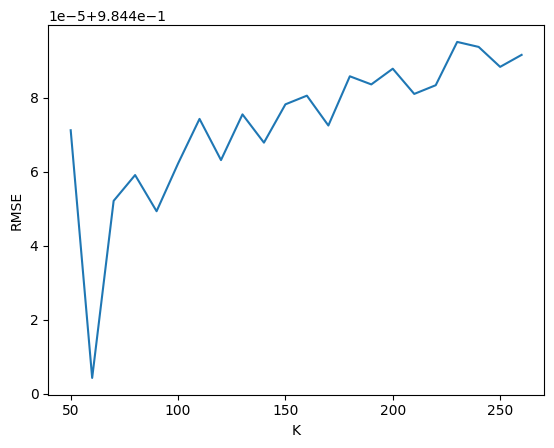

In [13]:
# 그래프로 확인

import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])

plt.xlabel('K')
plt.ylabel('RMSE')

plt.show()